In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

In [ ]:
batch_size = 8
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [3]:
mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Siamese network

$$L_{contrastive}(x_0, x_1, y) = \frac{1}{2} y \lVert f(x_0)-f(x_1)\rVert_2^2 + \frac{1}{2}(1-y)\{max(0, m-\lVert f(x_0)-f(x_1)\rVert_2)\}^2$$


In [7]:
# Set up data loaders
from datasets import SiameseMNIST

siamese_train_dataset = SiameseMNIST(train_dataset) # Returns pairs of images and target same/different
siamese_test_dataset = SiameseMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss

margin = 1.
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = ContrastiveLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [8]:
fit(siamese_train_loader, siamese_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.227718
Train: [12800/60000 (21%)]	Loss: 0.072131
Train: [25600/60000 (43%)]	Loss: 0.040934
Train: [38400/60000 (64%)]	Loss: 0.031564
Train: [51200/60000 (85%)]	Loss: 0.025739
Epoch: 1/20. Train set: Average loss: 0.0400
Epoch: 1/20. Validation set: Average loss: 0.0192
Train: [0/60000 (0%)]	Loss: 0.011247
Train: [12800/60000 (21%)]	Loss: 0.018377
Train: [25600/60000 (43%)]	Loss: 0.016195
Train: [38400/60000 (64%)]	Loss: 0.014791
Train: [51200/60000 (85%)]	Loss: 0.012396
Epoch: 2/20. Train set: Average loss: 0.0149
Epoch: 2/20. Validation set: Average loss: 0.0125
Train: [0/60000 (0%)]	Loss: 0.013657
Train: [12800/60000 (21%)]	Loss: 0.010621
Train: [25600/60000 (43%)]	Loss: 0.011142
Train: [38400/60000 (64%)]	Loss: 0.009533
Train: [51200/60000 (85%)]	Loss: 0.007959
Epoch: 3/20. Train set: Average loss: 0.0096
Epoch: 3/20. Validation set: Average loss: 0.0083
Train: [0/60000 (0%)]	Loss: 0.003296
Train: [12800/60000 (21%)]	Loss: 0.006550
Train: [25600/60000 (

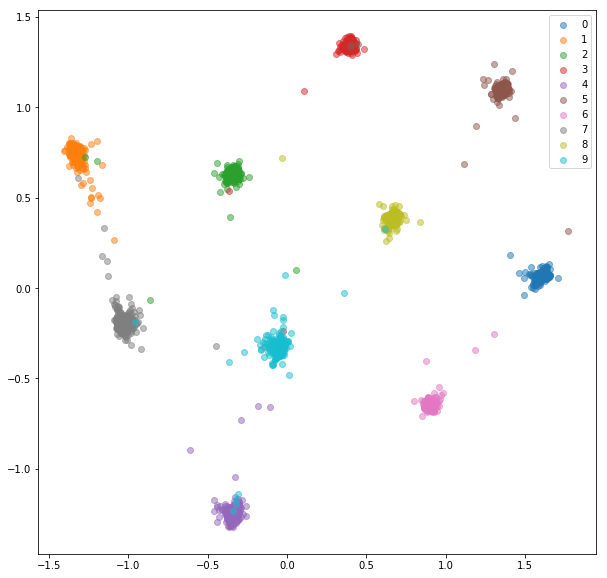

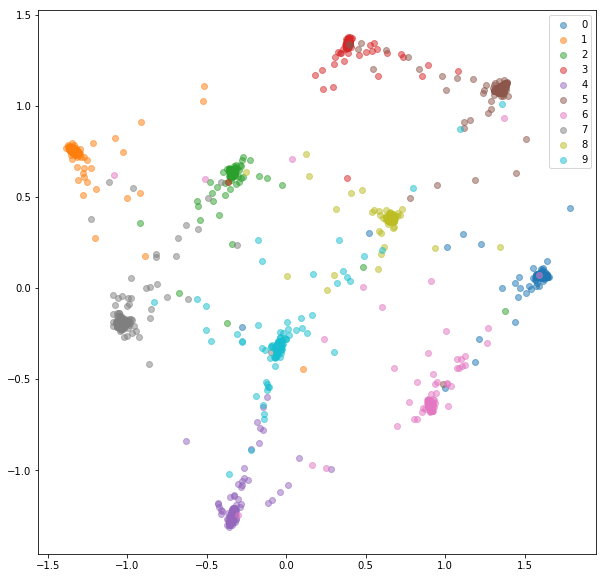

In [9]:
train_embeddings_cl, train_labels_cl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_cl, train_labels_cl)
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

# Triplet network

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] 

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

In [10]:
# Set up data loaders
from datasets import TripletMNIST

triplet_train_dataset = TripletMNIST(train_dataset) # Returns triplets of images
triplet_test_dataset = TripletMNIST(test_dataset)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader = torch.utils.data.DataLoader(triplet_train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet, TripletNet
from losses import TripletLoss

margin = 1.
embedding_net = EmbeddingNet()
model = TripletNet(embedding_net)
if cuda:
    model.cuda()
loss_fn = TripletLoss(margin)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

In [11]:
fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval)

Train: [0/60000 (0%)]	Loss: 0.999449
Train: [12800/60000 (21%)]	Loss: 0.299636
Train: [25600/60000 (43%)]	Loss: 0.142728
Train: [38400/60000 (64%)]	Loss: 0.092182
Train: [51200/60000 (85%)]	Loss: 0.068874
Epoch: 1/20. Train set: Average loss: 0.1398
Epoch: 1/20. Validation set: Average loss: 0.0578
Train: [0/60000 (0%)]	Loss: 0.046353
Train: [12800/60000 (21%)]	Loss: 0.055129
Train: [25600/60000 (43%)]	Loss: 0.052338
Train: [38400/60000 (64%)]	Loss: 0.040109
Train: [51200/60000 (85%)]	Loss: 0.042843
Epoch: 2/20. Train set: Average loss: 0.0467
Epoch: 2/20. Validation set: Average loss: 0.0444
Train: [0/60000 (0%)]	Loss: 0.013961
Train: [12800/60000 (21%)]	Loss: 0.030577
Train: [25600/60000 (43%)]	Loss: 0.030361
Train: [38400/60000 (64%)]	Loss: 0.035648
Train: [51200/60000 (85%)]	Loss: 0.032790
Epoch: 3/20. Train set: Average loss: 0.0321
Epoch: 3/20. Validation set: Average loss: 0.0364
Train: [0/60000 (0%)]	Loss: 0.028697
Train: [12800/60000 (21%)]	Loss: 0.034467
Train: [25600/60000 (

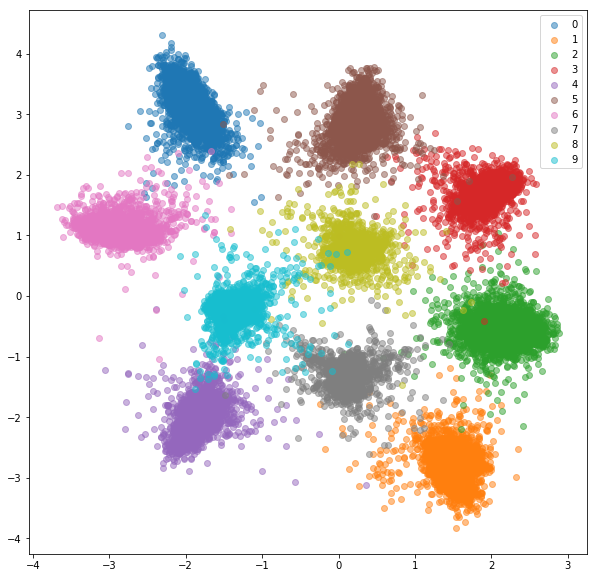

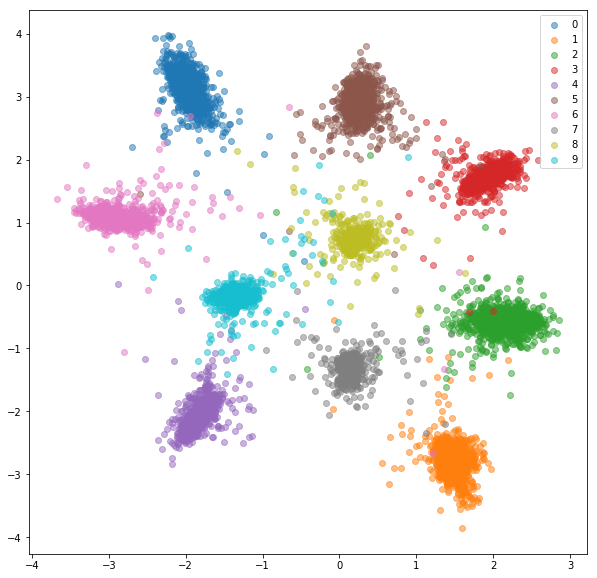

In [12]:
train_embeddings_tl, train_labels_tl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_tl, train_labels_tl)
val_embeddings_tl, val_labels_tl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_tl, val_labels_tl)